# Hyper-Parameters
1. Wavelet
2. Peak height
3. Peak width

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint as pp
from pyarrow import parquet as pq
import pywt
from scipy import signal as dsp
import seaborn as sns
from sklearn.externals import joblib
import yaml

from lib.utils import get_data_generator

sns.set()

In [64]:
with open('../../config.yaml', 'r') as f:
    cfg = yaml.load(f)

DATA_DIR = '../../data'
test_start = 8712  # TODO: What is this?

In [65]:
train_gen = get_data_generator('train', cfg.get('batch_size'))
train, meta_train = next(train_gen)
test_gen = get_data_generator('test', cfg.get('batch_size'))
test, meta_test = next(test_gen)

Text(0.5, 0.98, 'Training Examples: 0 [122 122 122]')

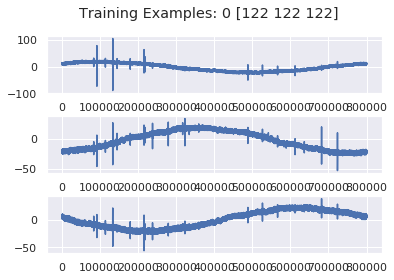

In [66]:
# Select random signal with all 3 phases
idx = np.random.randint(train.shape[0] / 3) * 3
signal = train[idx: idx + 3]
meta = meta_train.iloc[idx: idx + 3]

fig, ax = plt.subplots(3, 1, sharex='col')
for count in range(3):
    plt.subplot(((count + 1) * 1) + 310)
    plt.plot(train[idx + count])
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle("Training Examples: {} {}".format(meta_train.iloc[idx + count].target,
                                               meta.id_measurement.values))

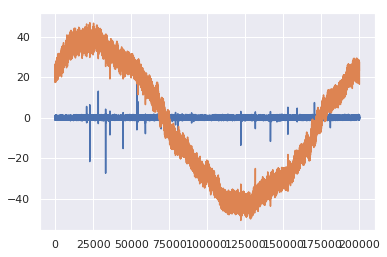

In [67]:
wavelet = cfg.get('mother_wavelet')
level = cfg.get('decomposition_level')

cA, cD = list(), list()
for phase in signal:
    cA_, *cD_ = pywt.wavedec(phase, wavelet, level=level)
    cA.append(cA_)
    cD.append(cD_[0])

%matplotlib inline
plt.plot(cD[0])
plt.plot(cA[0])
plt.show()

In [68]:
def sort_and_reindex_peaks(df):
    df = df.sort_values('peak_index', inplace=False)
    df = df.reset_index(inplace=False, drop=True)
    return df

In [69]:
def get_peak_info(cD):
    args = cfg.get('peak_finder_args')
    peaks, pinfo = dsp.find_peaks(cD, **args)
    pinfo.update({'peak_index': peaks})

    valleys, vinfo = dsp.find_peaks(-cD, **args)
    if 'peak_heights' in vinfo:
        vinfo.update({'peak_heights': -vinfo.get('peak_heights')})
    vinfo.update({'peak_index': valleys})
    
    return pd.concat([pd.DataFrame(pinfo), pd.DataFrame(vinfo)])

In [70]:
%matplotlib inline

Y_LIM = 200

def plot_phases(dfs):
    fig, ax = plt.subplots(3, 1, figsize=(22, 12), sharex=True)
    fig.suptitle("Measurements: {}, Targets: {}".format(meta.id_measurement.values,
                                                        meta.target.values), size=22)
    for i, sig in enumerate(cD):
        peak_marks = list(dfs[i].peak_index.values)
        ax[i].plot(cD[i], 'o', ls='-', markerfacecolor='r', markevery=peak_marks)
        ax[i].set_title("Peaks: {}".format(dfs[i].peak_index.count()))
        ax[i].set_xlim([0, len(cD[i])])
        ax[i].set_ylim([-Y_LIM, Y_LIM])
    plt.show()

In [71]:
def within_ratio(h1, h2, ratio):
    """Check if h2 (height2) has the opposite sign of h1 (height1)
    and is smaller by an amount within the given ratio
    """
    resp = False
    if (h1 < 0 and h2 > 0) or (h1 > 0 and h2 < 0):
        if (((abs(h1) * (1 - ratio)) < abs(h2)) and ((abs(h1) * (1 + ratio)) > abs(h2))):
            resp = True
    return resp

def remove_symmetric_pulses(df, height_ratio, max_dist, train_len):
    working_df = df.copy()
    to_remove = set()
    skip_until = -1 
    train_count = 0
    for idx, row in df.iterrows():
        # If indexes were already added to to_remove then we don't want to check the pulses
        if idx < skip_until:
            continue
        # if the next peak is within max_dist...
        try:
            if (row.peak_index + max_dist) >= df.iloc[idx + 1].peak_index:
                # ...and if the height is within height_ratio...
                if within_ratio(row.peak_heights, df.iloc[idx + 1].peak_heights, height_ratio):
                    # ...remove the symmetric pulses and the pulse train
                    to_remove.update([idx, idx + 1])
                    h2_index = df.iloc[idx + 1].peak_index
                    train = df[df.peak_index.between(h2_index, h2_index + train_len)]
                    train_count += len(train)
                    skip_until = train.index.values[-1]
                    to_remove.update(train.index.values)
        except IndexError:
            # End of df
            break
    for i in to_remove:
        working_df.drop(index=i, inplace=True)
    return working_df

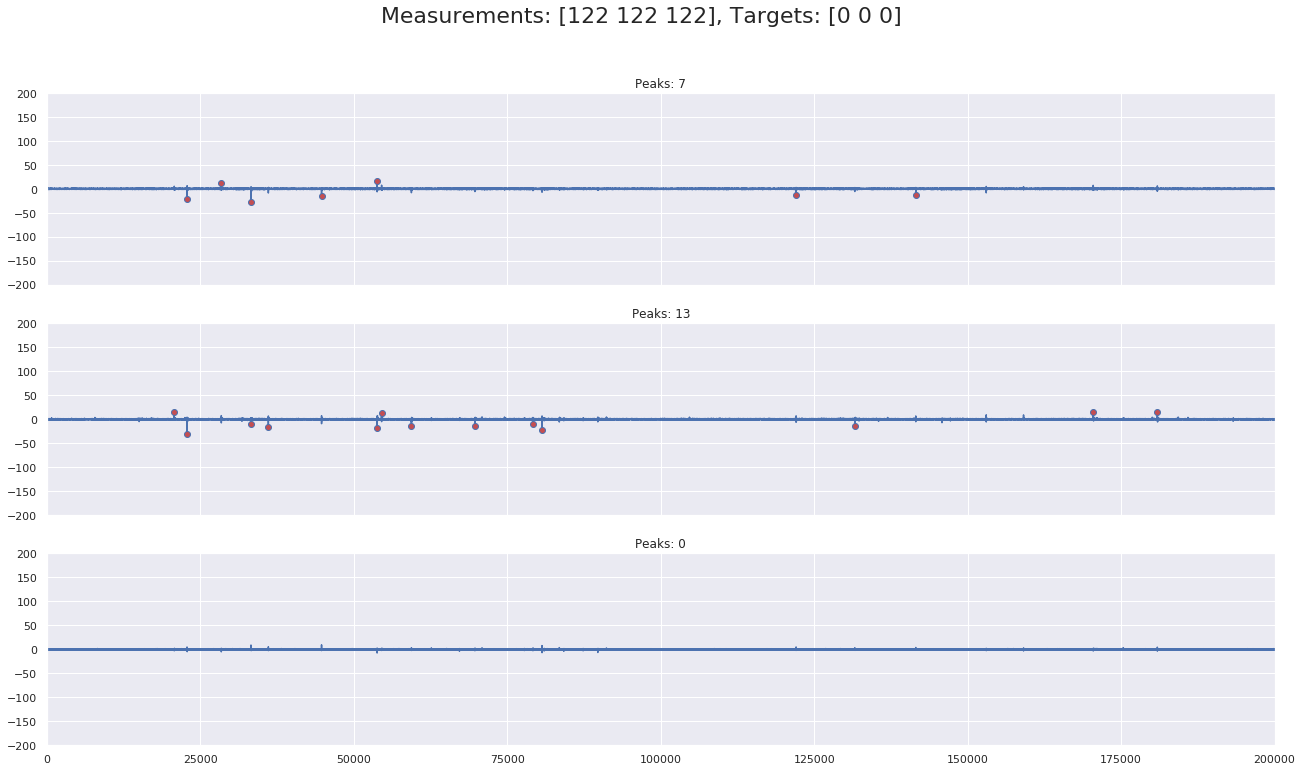

In [72]:
dfs = [sort_and_reindex_peaks(get_peak_info(sig)) for sig in cD]
plot_phases(dfs)

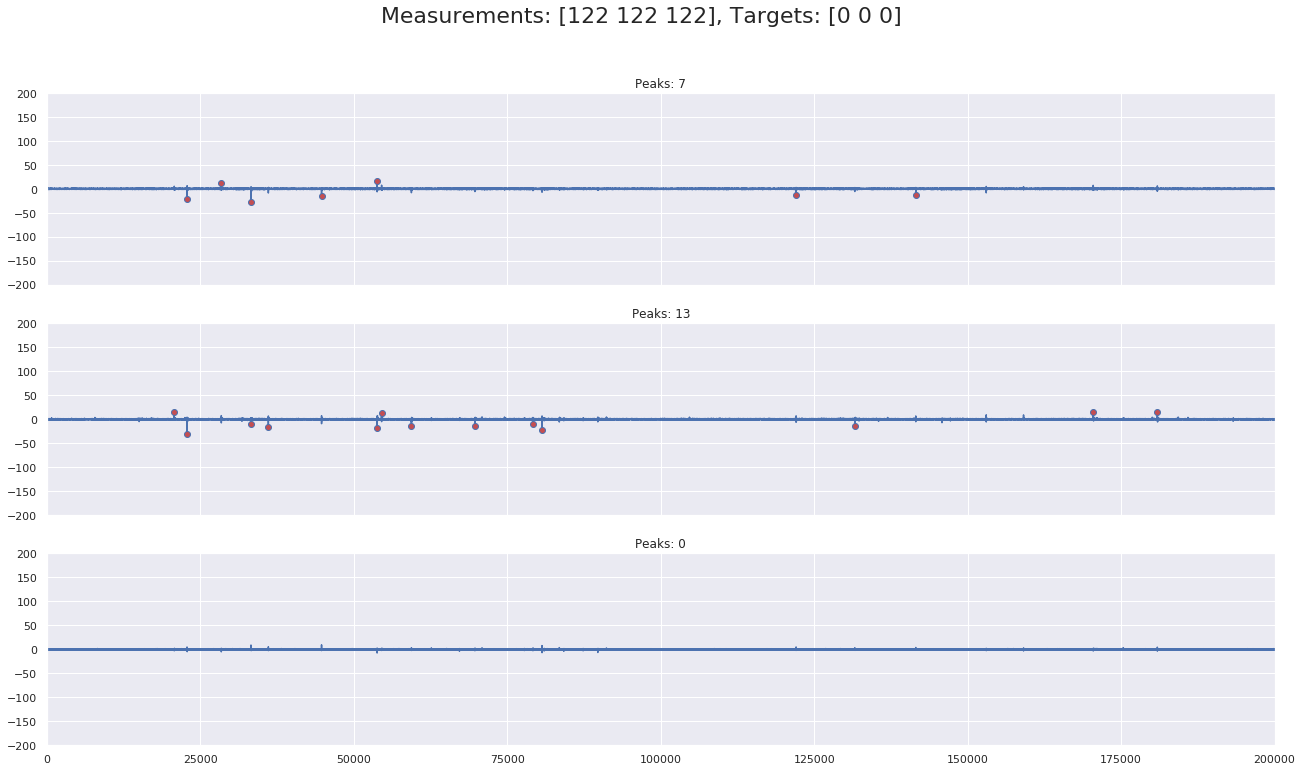

In [73]:
# Index 103 is good for canceling symmetric peaks

max_height = cfg.get('max_height')
height_ratio = cfg.get('max_height_ratio')
max_dist = cfg.get('max_distance')
max_peaks = cfg.get('max_ticks_removal')
trimmed_dfs = [remove_symmetric_pulses(df, height_ratio, max_dist, max_peaks) for df in dfs]
trimmed_dfs = [df[abs(df.peak_heights) < max_height] for df in trimmed_dfs]
trimmed_dfs = [sort_and_reindex_peaks(df) for df in trimmed_dfs]
plot_phases(trimmed_dfs)